In [2]:
# Required Libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Helper Functions
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return x > 0

def flatten(x):
    return x.reshape(x.shape[0], -1)

In [4]:
# Load Data
image_folder = r"C:\Users\barto\Desktop\Repos\MachineLearning\Project4\trainset1"
excel_file = r"Labels.csv"

# Load the Excel file containing labels
df = pd.read_csv(excel_file)

# Prepare data and labels
image_data = []
labels = []

# Function to preprocess images
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    return np.array(image)  # Convert to NumPy array

# Iterate through the Excel rows
for index, row in df.iterrows():
    image_id = row['ImageId']
    classification = row['ClassName']
    image_path = os.path.join(image_folder, image_id)
    
    # Check if the image exists and preprocess it
    if os.path.exists(image_path):
        try:
            image_array = preprocess_image(image_path)
            image_data.append(image_array)
            labels.append(classification)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Convert lists to numpy arrays
image_data = np.array(image_data).astype(np.float32)
image_data = image_data / 255.0
labels = np.array(labels)

In [5]:
# Encode labels to numerical values and one-hot encode
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels)
y_train_one_hot = np.zeros((labels_numeric.size, len(label_encoder.classes_)))
y_train_one_hot[np.arange(labels_numeric.size), labels_numeric] = 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(image_data, y_train_one_hot, test_size=0.2, random_state=42)
y_test = y_test.astype(int)
y_train = y_train.astype(int)

In [45]:
class ConvolutionalNeuralNetwork:
    def __init__(self, input_shape, num_classes):
        """
        Initialize the CNN.
        """
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Filters for two convolutional layers
        self.conv_filter1 = np.random.randn(3, 3, input_shape[2], 8) * 0.1  # 8 filters for layer 1
        self.conv_filter2 = np.random.randn(3, 3, 8, 16) * 0.1  # 16 filters for layer 2

        # Calculate flattened size after two max-pooling layers
        pool_size = 2
        # After two poolings, the height and width will be reduced by half twice
        output_height = (((input_shape[0] - 2) // pool_size) - 2) // pool_size  # After 2 poolings
        output_width = (((input_shape[1] - 2) // pool_size) - 2) // pool_size  # After 2 poolings
        flattened_size = 16 * output_height * output_width  # Number of channels * reduced height * reduced width

        # Fully connected and output layers
        self.fc_weights = np.random.randn(flattened_size, 128) * 0.1
        self.output_weights = np.random.randn(128, num_classes) * 0.1

        self.fc_bias = np.zeros((1, 128))
        self.output_bias = np.zeros((1, num_classes))

    def convolve(self, x, filters, stride=1, padding=0):
        """
        Perform convolution operation.
        """
        batch_size, height, width, channels = x.shape
        filter_height, filter_width, _, num_filters = filters.shape
        
        # Compute output dimensions
        output_height = (height - filter_height + 2 * padding) // stride + 1
        output_width = (width - filter_width + 2 * padding) // stride + 1
        output = np.zeros((batch_size, output_height, output_width, num_filters))
        
        for b in range(batch_size):
            for f in range(num_filters):
                for i in range(0, height - filter_height + 1, stride):
                    for j in range(0, width - filter_width + 1, stride):
                        region = x[b, i:i+filter_height, j:j+filter_width, :]
                        output[b, i // stride, j // stride, f] = np.sum(region * filters[:, :, :, f])
        return output

    def max_pool(self, x, pool_size=2, stride=2):
        """
        Perform max pooling operation.
        """
        batch_size, height, width, channels = x.shape
        
        # Compute output dimensions
        output_height = (height - pool_size) // stride + 1
        output_width = (width - pool_size) // stride + 1
        output = np.zeros((batch_size, output_height, output_width, channels))
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(0, height - pool_size + 1, stride):
                    for j in range(0, width - pool_size + 1, stride):
                        region = x[b, i:i+pool_size, j:j+pool_size, c]
                        output[b, i // stride, j // stride, c] = np.max(region)
        return output


    def forward(self, x):
        """
        Forward pass through the CNN.
        """
        # Convolutional layer 1
        self.conv_output1 = self.convolve(x, self.conv_filter1)
        self.conv_output1 = relu(self.conv_output1)

        # Max pooling layer 1
        self.pooled_output1 = self.max_pool(self.conv_output1)

        # Convolutional layer 2
        self.conv_output2 = self.convolve(self.pooled_output1, self.conv_filter2)
        self.conv_output2 = relu(self.conv_output2)

        # Max pooling layer 2
        self.pooled_output2 = self.max_pool(self.conv_output2)

        # Flatten
        self.flattened = flatten(self.pooled_output2)

        flattened_size = np.prod(self.pooled_output2.shape[1:])
        self.fc_weights = np.random.randn(flattened_size, 128) * 0.1

        # Fully connected layer
        self.fc_output = relu(np.dot(self.flattened, self.fc_weights) + self.fc_bias)

        # Output layer
        logits = np.dot(self.fc_output, self.output_weights) + self.output_bias
        predictions = softmax(logits)

        return predictions

    def backward(self, x, y_true, y_pred, learning_rate=0.01):
        """
        Optimized backward pass with reduced memory usage.
        """
        # Gradients for output layer
        output_error = y_pred - y_true
        d_output_weights = np.dot(self.fc_output.T, output_error)
        d_output_bias = np.sum(output_error, axis=0, keepdims=True)

        # Gradients for fully connected layer
        fc_error = np.dot(output_error, self.output_weights.T) * relu_derivative(self.fc_output)
        d_fc_weights = np.dot(self.flattened.T, fc_error)
        d_fc_bias = np.sum(fc_error, axis=0, keepdims=True)

        # Gradients for convolutional layer
        
        d_conv_filter1 = np.zeros_like(self.conv_filter1)
        d_conv_filter2 = np.zeros_like(self.conv_filter2)

        batch_size = x.shape[0]
        filter_height, filter_width, _, num_filters1 = self.conv_filter1.shape
        filter_height2, filter_width2, _, num_filters2 = self.conv_filter2.shape

        fc_error_reshaped = np.dot(fc_error, self.fc_weights.T).reshape(self.pooled_output2.shape)

        print(f"Expected pooled_output2 shape: {self.pooled_output2.shape}")
        print(f"Actual fc_error_reshaped shape: {fc_error_reshaped.shape}")

        # Compute gradients for the second convolutional layer
        for b in range(batch_size):
            for f in range(num_filters2):
                for i in range(fc_error_reshaped.shape[1]):
                    for j in range(fc_error_reshaped.shape[2]):
                        region = self.pooled_output1[b, i:i+filter_height2, j:j+filter_width2, :]
                        d_conv_filter2[:, :, :, f] += region * fc_error_reshaped[b, i, j, f]

        # fc_error_reshaped1 = fc_error_reshaped.reshape((-1, *self.pooled_output1.shape[1:]))

        for b in range(batch_size):
            for f in range(num_filters1):
                for i in range(self.conv_output1.shape[1] - filter_height + 1):  # Ensure valid range
                    for j in range(self.conv_output1.shape[2] - filter_width + 1):  # Ensure valid range
                        region = x[b, i:i+filter_height, j:j+filter_width, :]
                        d_conv_filter1[:, :, :, f] += region * d_conv_filter2[b, i, j, f]


        # Update weights and biases
        self.output_weights -= learning_rate * d_output_weights
        self.output_bias -= learning_rate * d_output_bias
        self.fc_weights -= learning_rate * d_fc_weights
        self.fc_bias -= learning_rate * d_fc_bias
        self.conv_filter1 -= learning_rate * d_conv_filter1
        self.conv_filter2 -= learning_rate * d_conv_filter2

    def train(self, x_train, y_train, num_epochs=10, learning_rate=0.01):
        """
        Train the CNN using SGD.
        """
        for epoch in range(num_epochs):
            y_pred = self.forward(x_train)
            print('We forwarded yippee!')
            loss = cross_entropy_loss(y_train, y_pred)
            self.backward(x_train, y_train, y_pred, learning_rate)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    def calculate_accuracy(self, x_test, y_test):
        """
        Calculate the accuracy of the CNN.
        """
        y_pred = self.forward(x_test)
        predicted_classes = np.argmax(y_pred, axis=1)
        true_classes = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes) * 100
        return accuracy

In [46]:
# Initialize and Train the CNN
input_shape = (190, 190, 3)
num_classes = len(label_encoder.classes_)
cnn = ConvolutionalNeuralNetwork(input_shape=input_shape, num_classes=num_classes)

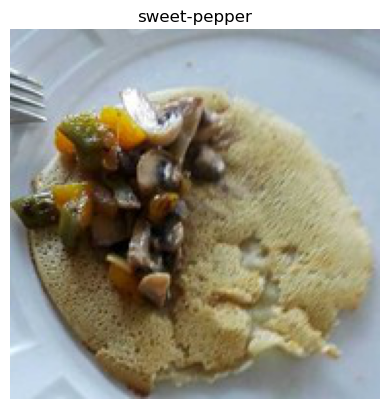

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

number = 20
plt.imshow(image_data[number, :, :, :])
plt.title(f"{labels[number]}")
plt.axis('off')  # Turn off axis for a cleaner look
plt.show()

In [ ]:
cnn.forward(X_train)

In [47]:
batch_size = 32
num_samples = len(X_train)
for start in range(0, num_samples, batch_size):
    end = start + batch_size
    x_batch = X_train[start:end]
    y_batch = y_train[start:end]
    cnn.train(x_batch, y_batch, num_epochs=2, learning_rate=0.001)

# Evaluate
accuracy = cnn.calculate_accuracy(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}%")

We forwarded yippee!
Expected pooled_output2 shape: (32, 46, 46, 16)
Actual fc_error_reshaped shape: (32, 46, 46, 16)


IndexError: index 8 is out of bounds for axis 2 with size 8

In [53]:
import numpy as np

# ------------------
# Some helper functions
# ------------------
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(x.dtype)

def softmax(x):
    # Softmax per row (batch axis = 0)
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    # y_true and y_pred shape: (batch_size, num_classes)
    eps = 1e-9
    return -np.sum(y_true * np.log(y_pred + eps)) / y_true.shape[0]

def flatten(x):
    # Flatten all but the batch dimension
    return x.reshape(x.shape[0], -1)


# ------------------
# CNN Class
# ------------------
class ConvolutionalNeuralNetwork2:
    def __init__(self, input_shape, num_classes):
        """
        input_shape = (height, width, channels)
        """
        self.input_shape = input_shape
        self.num_classes = num_classes

        # ------------------
        # 1) Initialize Filters for two Conv Layers
        #    Let's keep the example filter sizes at (3,3) 
        #    and set the # of output channels as 8 then 16.
        # ------------------
        self.conv_filter1 = np.random.randn(3, 3, input_shape[2], 8)  * 0.1  # (3,3,channels_in, 8)
        self.conv_filter2 = np.random.randn(3, 3, 8, 16)              * 0.1  # (3,3,8,16)

        # We'll do a stride=1, no padding in both conv layers
        self.stride_c = 1
        self.padding_c = 0

        # ------------------
        # 2) Figure out shape after first Conv+Pool, then second Conv+Pool
        #    Each conv (3x3, stride=1, pad=0) reduces H,W by 2 in each dimension:
        #       out_height = in_height - 3 + 1 = in_height - 2
        #    Then max-pooling with pool_size=2, stride=2 halves the H/W again.
        #    So for each conv+pool block:
        #       final H/W = ( (H - 2) / 2 ) = (H - 2) // 2
        #
        #    Doing that twice:
        #       After 1st block:  H1 = ( (H - 2) // 2 ), W1 = ( (W - 2) // 2 )
        #       After 2nd block:  H2 = ( (H1 - 2) // 2 ), W2 = ( (W1 - 2) // 2 )
        # ------------------
        def after_conv(h):
            return h - 2  # 3x3 filter, stride=1 => output size = h - 2

        def after_pool(h):
            return h // 2 # pool_size=2, stride=2 => halves dimension

        H0, W0, C0 = input_shape
        H1, W1 = after_pool(after_conv(H0)), after_pool(after_conv(W0))
        H2, W2 = after_pool(after_conv(H1)), after_pool(after_conv(W1))

        # channels after 2nd conv is 16
        flattened_size = 16 * H2 * W2

        # ------------------
        # 3) Fully Connected weights + Output
        # ------------------
        self.fc_weights     = np.random.randn(flattened_size, 128) * 0.1
        self.fc_bias        = np.zeros((1, 128))
        self.output_weights = np.random.randn(128, num_classes) * 0.1
        self.output_bias    = np.zeros((1, num_classes))

        # -----------
        # Hyperparams for pooling:
        # -----------
        self.pool_size   = 2
        self.pool_stride = 2

        # We'll store forward-pass intermediates here
        self.conv_output1  = None
        self.relu_output1  = None
        self.pool_output1  = None
        self.pool_mask1    = None  # for max-pool unpooling
        self.conv_output2  = None
        self.relu_output2  = None
        self.pool_output2  = None
        self.pool_mask2    = None
        self.flattened     = None
        self.fc_output     = None

        # Adagrad accumulators
        self.adagrad_accum = {
            "conv_filter1": np.zeros_like(self.conv_filter1),
            "conv_filter2": np.zeros_like(self.conv_filter2),
            "fc_weights": np.zeros_like(self.fc_weights),
            "fc_bias": np.zeros_like(self.fc_bias),
            "output_weights": np.zeros_like(self.output_weights),
            "output_bias": np.zeros_like(self.output_bias),
        }

        self.epsilon = 1e-8  # Small constant for numerical stability

    def update_parameters_adagrad(self, grads, learning_rate):
        """
        Update parameters using the Adagrad optimizer.
        grads: Dictionary containing gradients for each parameter.
        learning_rate: Initial learning rate.
        """
        for param_name, grad in grads.items():
            self.adagrad_accum[param_name] += grad**2
            adjustment = learning_rate / (np.sqrt(self.adagrad_accum[param_name]) + self.epsilon)
            setattr(self, param_name, getattr(self, param_name) - adjustment * grad)
    # ------------------------------------------------------------------
    # Forward Pass Building Blocks
    # ------------------------------------------------------------------
    def convolve_forward(self, x, filters, stride=1, padding=0):
        """
        x shape: (batch_size, H, W, in_channels)
        filters shape: (fH, fW, in_channels, out_channels)
        Returns: (batch_size, out_H, out_W, out_channels)
        """
        batch_size, in_height, in_width, in_channels = x.shape
        fH, fW, _, out_channels = filters.shape

        out_height = (in_height - fH + 2 * padding) // stride + 1
        out_width  = (in_width  - fW + 2 * padding) // stride + 1

        # Output feature map
        out = np.zeros((batch_size, out_height, out_width, out_channels))

        # Naive loop
        for b in range(batch_size):
            for oh in range(0, out_height):
                for ow in range(0, out_width):
                    # region in input
                    h_start = oh * stride
                    h_end   = h_start + fH
                    w_start = ow * stride
                    w_end   = w_start + fW

                    region = x[b, h_start:h_end, w_start:w_end, :]  # shape (fH, fW, in_channels)
                    for c in range(out_channels):
                        out[b, oh, ow, c] = np.sum(region * filters[:, :, :, c])

        return out

    def max_pool_forward(self, x, pool_size=2, stride=2):
        """
        x shape: (batch_size, H, W, channels)
        Return: 
          pooled: (batch_size, out_H, out_W, channels)
          mask:   same shape as pooled, storing the index of the maximum within each pooling window
        """
        batch_size, in_height, in_width, in_channels = x.shape
        out_height = (in_height - pool_size) // stride + 1
        out_width  = (in_width  - pool_size) // stride + 1

        pooled = np.zeros((batch_size, out_height, out_width, in_channels))
        mask   = np.zeros((batch_size, out_height, out_width, in_channels), dtype=np.int32)

        for b in range(batch_size):
            for c in range(in_channels):
                for oh in range(out_height):
                    for ow in range(out_width):
                        h_start = oh * stride
                        h_end   = h_start + pool_size
                        w_start = ow * stride
                        w_end   = w_start + pool_size

                        # region: shape (pool_size, pool_size)
                        region = x[b, h_start:h_end, w_start:w_end, c]
                        region_flat = region.flatten()
                        max_idx = np.argmax(region_flat)
                        pooled[b, oh, ow, c] = region_flat[max_idx]
                        mask[b, oh, ow, c]   = max_idx  # store index of the max
        return pooled, mask

    # ------------------------------------------------------------------
    # Backward Pass Building Blocks
    # ------------------------------------------------------------------
    def convolve_backward(self, d_out, x, filters, stride=1, padding=0):
        """
        d_out: gradient wrt conv output, shape (batch_size, out_H, out_W, out_channels)
        x:     original input to conv_forward, shape (batch_size, H, W, in_channels)
        filters: shape (fH, fW, in_channels, out_channels)

        Returns: 
          d_x: gradient wrt x, same shape as x
          d_filters: gradient wrt filters, same shape as filters
        """
        batch_size, in_height, in_width, in_channels = x.shape
        fH, fW, _, out_channels = filters.shape

        d_x       = np.zeros_like(x)
        d_filters = np.zeros_like(filters)

        out_height, out_width = d_out.shape[1], d_out.shape[2]

        # Naive loop: accumulate partial derivatives
        for b in range(batch_size):
            for oh in range(out_height):
                for ow in range(out_width):
                    h_start = oh * stride
                    h_end   = h_start + fH
                    w_start = ow * stride
                    w_end   = w_start + fW

                    # gradient at output location for each out_channel
                    for c in range(out_channels):
                        grad_val = d_out[b, oh, ow, c]
                        # region from the input x
                        region_x = x[b, h_start:h_end, w_start:w_end, :]

                        # accumulate w.r.t. filters
                        d_filters[:, :, :, c] += region_x * grad_val

                        # accumulate w.r.t. input x
                        d_x[b, h_start:h_end, w_start:w_end, :] += filters[:, :, :, c] * grad_val

        return d_x, d_filters

    def max_pool_backward(self, d_out, x_shape, pool_mask, pool_size=2, stride=2):
        """
        Backprop for max-pooling.
        d_out:   gradient wrt pooled output, shape = same as pool_mask
        x_shape: shape of the original input to the forward pooling
        pool_mask: each element is the argmax index in [0..pool_size*pool_size-1]
        Return: d_x with shape = x_shape
        """
        batch_size, in_height, in_width, channels = x_shape
        out_height, out_width = d_out.shape[1], d_out.shape[2]

        d_x = np.zeros(x_shape)

        for b in range(batch_size):
            for c in range(channels):
                for oh in range(out_height):
                    for ow in range(out_width):
                        grad_val = d_out[b, oh, ow, c]
                        max_i = pool_mask[b, oh, ow, c]  # integer in [0, pool_size*pool_size)
                        # unravel the index
                        # e.g. for pool_size=2, max_i = 0..3
                        row_offset = max_i // pool_size
                        col_offset = max_i % pool_size

                        h_start = oh * stride
                        w_start = ow * stride

                        d_x[b, h_start + row_offset, w_start + col_offset, c] += grad_val

        return d_x

    # ------------------------------------------------------------------
    # Full Forward
    # ------------------------------------------------------------------
    def forward(self, x):
        """
        Full forward pass. Save intermediates for backprop.
        x shape: (batch_size, H, W, C)
        """
        # ---------- 1) Conv layer 1
        self.conv_output1 = self.convolve_forward(x, self.conv_filter1, 
                                                  stride=self.stride_c, 
                                                  padding=self.padding_c)
        self.relu_output1 = relu(self.conv_output1)

        # ---------- 2) Max pool 1
        self.pool_output1, self.pool_mask1 = self.max_pool_forward(self.relu_output1,
                                                                   pool_size=self.pool_size,
                                                                   stride=self.pool_stride)

        # ---------- 3) Conv layer 2
        self.conv_output2 = self.convolve_forward(self.pool_output1, self.conv_filter2,
                                                  stride=self.stride_c,
                                                  padding=self.padding_c)
        self.relu_output2 = relu(self.conv_output2)

        # ---------- 4) Max pool 2
        self.pool_output2, self.pool_mask2 = self.max_pool_forward(self.relu_output2,
                                                                   pool_size=self.pool_size,
                                                                   stride=self.pool_stride)

        # ---------- 5) Flatten
        self.flattened = flatten(self.pool_output2)

        # ---------- 6) FC layer
        fc_in = self.flattened
        fc_linear = np.dot(fc_in, self.fc_weights) + self.fc_bias
        self.fc_output = relu(fc_linear)

        # ---------- 7) Output layer
        logits = np.dot(self.fc_output, self.output_weights) + self.output_bias
        predictions = softmax(logits)

        return predictions

    # ------------------------------------------------------------------
    # Full Backward
    # ------------------------------------------------------------------
    def backward(self, x, y_true, y_pred, learning_rate=0.01):
        """
        Full backprop through all layers: conv1 -> pool1 -> conv2 -> pool2 -> fc -> output
        """
        batch_size = x.shape[0]

        # ---------------------------
        # 1) Gradient wrt output layer
        #    y_pred: (batch_size, num_classes)
        #    y_true: (batch_size, num_classes)
        #    cross-entropy => d_logits = (y_pred - y_true) / batch_size
        # ---------------------------
        d_logits = (y_pred - y_true) / batch_size  # shape (batch_size, num_classes)

        # Grad wrt output weights/bias
        d_output_weights = np.dot(self.fc_output.T, d_logits)  # shape (128, num_classes)
        d_output_bias    = np.sum(d_logits, axis=0, keepdims=True)  # shape (1, num_classes)

        # ---------------------------
        # 2) Backprop into FC output
        #    fc_output shape: (batch_size, 128)
        #    need gradient wrt fc_output
        # ---------------------------
        d_fc_output = np.dot(d_logits, self.output_weights.T)  # shape (batch_size, 128)

        # Because we have ReLU on FC output, multiply by relu_derivative(fc_output)
        d_fc_output *= relu_derivative(self.fc_output)

        # ---------------------------
        # 3) Gradient wrt FC weights/bias
        #    Flattened input was (batch_size, flattened_size)
        # ---------------------------
        d_fc_weights = np.dot(self.flattened.T, d_fc_output)  # shape (flattened_size, 128)
        d_fc_bias    = np.sum(d_fc_output, axis=0, keepdims=True)

        # ---------------------------
        # 4) Backprop into the flattened input
        # ---------------------------
        d_flattened = np.dot(d_fc_output, self.fc_weights.T)  # shape (batch_size, flattened_size)

        # Reshape gradient to match pool_output2 shape
        d_pool_output2 = d_flattened.reshape(self.pool_output2.shape)

        # ---------------------------
        # 5) Unpool through max-pool2
        #    to get gradient wrt conv_output2 (after ReLU)
        # ---------------------------
        d_relu_output2 = self.max_pool_backward(d_pool_output2,
                                                self.conv_output2.shape,
                                                self.pool_mask2,
                                                pool_size=self.pool_size,
                                                stride=self.pool_stride)

        # Apply ReLU derivative on conv_output2
        d_conv_output2 = d_relu_output2 * relu_derivative(self.conv_output2)

        # ---------------------------
        # 6) Conv2 backward
        #    This returns gradient wrt pool_output1
        # ---------------------------
        d_pool_output1, d_conv_filter2 = self.convolve_backward(d_conv_output2,
                                                                self.pool_output1,
                                                                self.conv_filter2,
                                                                stride=self.stride_c,
                                                                padding=self.padding_c)

        # ---------------------------
        # 7) Unpool through max-pool1
        #    to get gradient wrt relu_output1 (which is conv_output1 after ReLU)
        # ---------------------------
        d_relu_output1 = self.max_pool_backward(d_pool_output1,
                                                self.conv_output1.shape,
                                                self.pool_mask1,
                                                pool_size=self.pool_size,
                                                stride=self.pool_stride)

        # Apply ReLU derivative on conv_output1
        d_conv_output1 = d_relu_output1 * relu_derivative(self.conv_output1)

        # ---------------------------
        # 8) Conv1 backward
        # ---------------------------
        d_x, d_conv_filter1 = self.convolve_backward(d_conv_output1,
                                                     x,
                                                     self.conv_filter1,
                                                     stride=self.stride_c,
                                                     padding=self.padding_c)

        # We typically don’t update x (the data), so we won’t do so here.

        # --------------
        # Update weights
        # --------------
        grads = {
            "conv_filter1": d_conv_filter1,
            "conv_filter2": d_conv_filter2,
            "fc_weights": d_fc_weights,
            "fc_bias": d_fc_bias,
            "output_weights": d_output_weights,
            "output_bias": d_output_bias,
        }

        # Update weights using Adagrad
        self.update_parameters_adagrad(grads, learning_rate)


    # ------------------------------------------------------------------
    # Training & Accuracy
    # ------------------------------------------------------------------
    def train(self, x_train, y_train, num_epochs=10, learning_rate=0.01):
        """
        Simple training loop (SGD on the entire batch).
        """
        for epoch in range(num_epochs):
            y_pred = self.forward(x_train)              # forward
            loss = cross_entropy_loss(y_train, y_pred)  # compute loss
            self.backward(x_train, y_train, y_pred, learning_rate=learning_rate)  # backward
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    def calculate_accuracy(self, x_test, y_test):
        """
        Evaluate on test set
        """
        y_pred = self.forward(x_test)
        predicted_classes = np.argmax(y_pred, axis=1)
        true_classes      = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes) * 100
        return accuracy


In [54]:
# Initialize and Train the CNN
input_shape = (190, 190, 3)
num_classes = len(label_encoder.classes_)
cnn = ConvolutionalNeuralNetwork2(input_shape=input_shape, num_classes=num_classes)

In [51]:
batch_size = 32
num_samples = len(X_train)
for start in range(0, num_samples, batch_size):
    end = start + batch_size
    x_batch = X_train[start:end]
    y_batch = y_train[start:end]
    cnn.train(x_batch, y_batch, num_epochs=2, learning_rate=0.001)

# Evaluate
accuracy = cnn.calculate_accuracy(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/2, Loss: 6.0037
Epoch 2/2, Loss: 5.5503
Epoch 1/2, Loss: 5.1339
Epoch 2/2, Loss: 4.8909
Epoch 1/2, Loss: 5.3766
Epoch 2/2, Loss: 5.2009
Epoch 1/2, Loss: 4.5090
Epoch 2/2, Loss: 4.4216
Epoch 1/2, Loss: 4.9723
Epoch 2/2, Loss: 4.8449
Epoch 1/2, Loss: 4.3961
Epoch 2/2, Loss: 4.3278
Epoch 1/2, Loss: 4.5465
Epoch 2/2, Loss: 4.5053
Epoch 1/2, Loss: 4.3409
Epoch 2/2, Loss: 4.3088
Epoch 1/2, Loss: 4.3514
Epoch 2/2, Loss: 4.3233
Epoch 1/2, Loss: 4.6530
Epoch 2/2, Loss: 4.6005
Epoch 1/2, Loss: 4.3298
Epoch 2/2, Loss: 4.3137
Epoch 1/2, Loss: 4.1979
Epoch 2/2, Loss: 4.1855
Epoch 1/2, Loss: 4.4437
Epoch 2/2, Loss: 4.4101
Epoch 1/2, Loss: 4.2158
Epoch 2/2, Loss: 4.1924
Epoch 1/2, Loss: 4.2833
Epoch 2/2, Loss: 4.2690
Epoch 1/2, Loss: 4.2464
Epoch 2/2, Loss: 4.2243
Epoch 1/2, Loss: 4.2131
Epoch 2/2, Loss: 4.1893
Epoch 1/2, Loss: 4.2423
Epoch 2/2, Loss: 4.2272
Epoch 1/2, Loss: 4.3014
Epoch 2/2, Loss: 4.2817
Epoch 1/2, Loss: 4.1411
Epoch 2/2, Loss: 4.1155
Epoch 1/2, Loss: 4.2226
Epoch 2/2, Loss:

In [52]:
batch_size = 200
num_samples = len(image_data)
for start in range(0, num_samples, batch_size):
    end = start + batch_size
    x_batch = image_data[start:end]
    y_batch = image_data[start:end]
    cnn.train(x_batch, y_batch, num_epochs=5, learning_rate=0.005)

# Evaluate
accuracy = cnn.calculate_accuracy(image_data, y)
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/5, Loss: 4.0793
Epoch 2/5, Loss: 4.0738
Epoch 3/5, Loss: 4.0692
Epoch 4/5, Loss: 4.0643
Epoch 5/5, Loss: 4.0597
Epoch 1/5, Loss: 4.1182
Epoch 2/5, Loss: 4.1093
Epoch 3/5, Loss: 4.1010
Epoch 4/5, Loss: 4.0936
Epoch 5/5, Loss: 4.0870
Epoch 1/5, Loss: 4.1191
Epoch 2/5, Loss: 4.1103
Epoch 3/5, Loss: 4.1049
Epoch 4/5, Loss: 4.1000
Epoch 5/5, Loss: 4.0947
Epoch 1/5, Loss: 4.0960
Epoch 2/5, Loss: 4.0919
Epoch 3/5, Loss: 4.0885
Epoch 4/5, Loss: 4.0847
Epoch 5/5, Loss: 4.0801
Epoch 1/5, Loss: 4.1223
Epoch 2/5, Loss: 4.1133
Epoch 3/5, Loss: 4.1045
Epoch 4/5, Loss: 4.0964
Epoch 5/5, Loss: 4.0903
Epoch 1/5, Loss: 4.1425
Epoch 2/5, Loss: 4.1272
Epoch 3/5, Loss: 4.1179
Epoch 4/5, Loss: 4.1104
Epoch 5/5, Loss: 4.1046
Epoch 1/5, Loss: 4.1164
Epoch 2/5, Loss: 4.1053
Epoch 3/5, Loss: 4.0976
Epoch 4/5, Loss: 4.0937
Epoch 5/5, Loss: 4.0909
Epoch 1/5, Loss: 4.0491
Epoch 2/5, Loss: 4.0382
Epoch 3/5, Loss: 4.0300
Epoch 4/5, Loss: 4.0232
Epoch 5/5, Loss: 4.0168
Epoch 1/5, Loss: 4.0497
Epoch 2/5, Loss: